In [30]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## PS matrix

In [31]:
import numpy as np
import density_field_library as DFL
import Pk_library as PKL
# import pyfftw

grid              = 256    #grid size
BoxSize           = 1000.0 #Mpc/h
Rayleigh_sampling = 1      #whether sampling the Rayleigh distribution for modes amplitudes
threads           = 1      #number of openmp threads

# Define fundamental and Nyquist modes
kF,kN,_,_,kmax = PKL.frequencies(BoxSize, grid)

In [32]:
## Compute smooth window
filt = np.zeros((grid,grid,grid))
x_arr = np.arange(grid)
filt1d = np.empty(grid)
filt1d[x_arr <= grid//2-grid//8] = 1.
filt1d[x_arr > 3*grid//8] = (1+np.cos((x_arr[x_arr>3*grid//8]-3*grid//8)/(grid//8)*np.pi))/2
filt1d[x_arr < grid//8] = (1+np.cos((x_arr[x_arr<grid//8]-grid//8)/(grid//8)*np.pi))/2
filt1d[x_arr > grid//2] = 0.

filt1d[x_arr<=grid//2] = 1.

filt = np.asarray(np.meshgrid(*[filt1d for _ in range(3)])).prod(axis=0)

In [33]:
def compute_pk_out(pk_index, seed, kmax=0.3, plot=False):

    # Create k and P arrays
    k_arr = list(np.arange(0,2*kF*(pk_index+1)-1e-10,2*kF))+[2*kF*(pk_index+1)*(1-1e-10),2*kF*(pk_index+1),2*kF*(pk_index+2)*(1-1e-10),2*kF*(pk_index+2)]+list(np.arange(2*kF*(pk_index+2)+1e-6,kN,2*kF))
    k_arr = np.asarray(k_arr)
    pk_arr = np.zeros_like(k_arr)
    # Add power to a specific mode only
    pk_arr[(k_arr>=(pk_index+1)*2*kF)&(k_arr<(pk_index+2)*2*kF)] = 1.
    
    density_r = DFL.gaussian_field_3D(grid, k_arr.astype(np.float32), pk_arr.astype(float32), 1, seed+pk_index*1000,
                                  BoxSize, 1, False)
    
    # Now cut this down and zero-pad it 
    # padding width is ~ 100 Mpc here
    #density_cut = np.zeros((grid,grid,grid))
    #density_cut[:grid//2,:grid//2,:grid//2] = density_r[:grid//2,:grid//2,:grid//2]
    density_cut = density_r*filt
    
    # Remove mean of map
    density_cut -= np.mean(density_cut)
    
    if plot: plt.imshow(density_cut[:,:,:grid//2].mean(axis=2))
    
    # Compute power spectrum (dropping first mode [old fundamental])
    Pk = PKL.Pk(density_cut.astype(np.float32), BoxSize, -1, 'None', threads, False)
    k_out = Pk.k3D[1:]
    Pk_out = Pk.Pk[1:,0]
    Nmodes = Pk.Nmodes3D[1:]
    
    # Rebin since fundamental has changed
    k_out =  (k_out[1::2]*Nmodes[1::2] +k_out[:-1:2] *Nmodes[:-1:2])/(Nmodes[1::2]+Nmodes[:-1:2])
    Pk_out = (Pk_out[1::2]*Nmodes[1::2]+Pk_out[:-1:2]*Nmodes[:-1:2])/(Nmodes[1::2]+Nmodes[:-1:2])
    
    return k_out[k_out<kmax], Pk_out[k_out<kmax]

In [34]:
# Create k and P arrays
pk_index = 5 
seed = 0
k_arr = list(np.arange(0,2*kF*(pk_index+1)-1e-10,2*kF))+[2*kF*(pk_index+1)*(1-1e-10),2*kF*(pk_index+1),2*kF*(pk_index+2)*(1-1e-10),2*kF*(pk_index+2)]+list(np.arange(2*kF*(pk_index+2)+1e-6,kN,2*kF))
k_arr = np.asarray(k_arr)
pk_arr = np.zeros_like(k_arr)
# Add power to a specific mode only
pk_arr[(k_arr>=(pk_index+1)*2*kF)&(k_arr<(pk_index+2)*2*kF)] = 1.

density_r = DFL.gaussian_field_3D(grid, k_arr.astype(np.float32), pk_arr.astype(float32), 1, seed+pk_index*1000,
                              BoxSize, 1, False)



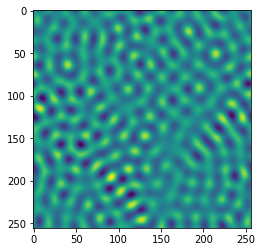

In [35]:
plt.imshow(density_r.sum(axis=0))

## removing mean!

In [36]:
# %timeit compute_pk_out(5, 52, plot=False)


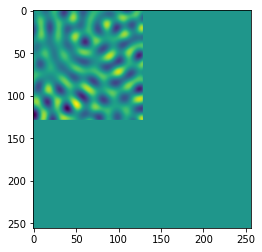

In [37]:
k_out, Pk_out = compute_pk_out(5, 52, plot=True)

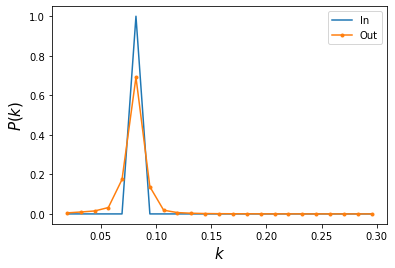

In [38]:
pk_in = np.zeros(len(k_out))
pk_in[5]=1
plt.plot(k_out,pk_in,label='In')
plt.plot(k_out,Pk_out/np.mean(filt**2),marker='.',label='Out')
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$P(k)$',fontsize=15)
plt.legend();

In [39]:
Pk_out.sum()

0.14070377692774466

In [40]:
N_seed = 1
Pk_mats = np.zeros((N_seed,len(k_out),len(k_out)))
for seed in range(N_seed):
    print("Using seed %d"%seed)
    for index in range(len(k_out)):
        Pk_mats[seed,index] = compute_pk_out(index, seed)[-1]

Using seed 0


In [46]:
k_out

array([0.01957139, 0.03198397, 0.04432056, 0.0567436 , 0.06914289,
       0.08178471, 0.09438618, 0.10688622, 0.11941391, 0.13195351,
       0.1445141 , 0.15711811, 0.16972297, 0.18230008, 0.19481942,
       0.20737558, 0.21992892, 0.2324651 , 0.24502511, 0.25759652,
       0.27018206, 0.28276864, 0.29531157])

In [48]:
kcheck = np.arange(4*kF, k_out.max(), kF)

In [ ]:
Pk_mats_finer = []
for m in Pk_mats:
    for index in range(m[index]

<ErrorbarContainer object of 3 artists>

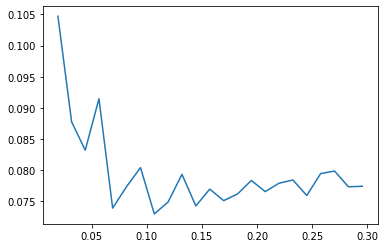

In [41]:
plt.errorbar(k_out,np.diag(Pk_mats.mean(axis=0)),yerr=np.diag(Pk_mats.std(axis=0)))

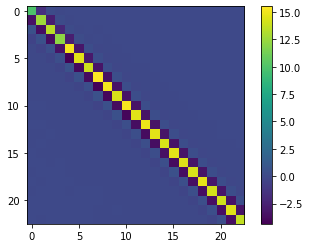

In [42]:
Pk_mat = Pk_mats.mean(axis=0)
plt.imshow(np.linalg.inv(Pk_mat))
plt.colorbar();

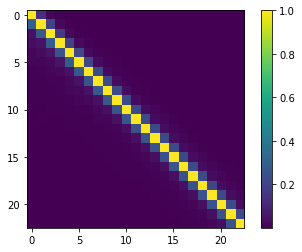

In [43]:
corr = Pk_mat/np.sqrt(np.outer(np.diag(Pk_mat),np.diag(Pk_mat)))
plt.imshow(corr);plt.colorbar();

### Now generate boxes with known input PS

In [ ]:
from classy import Class
cosmo = Class()
cosmo.set({'output':'mPk'})
cosmo.compute()
k_arr = np.arange(0,5*kN,kF)
pk_arr = np.asarray([cosmo.pk_lin(kk*cosmo.h(),0)*cosmo.h()**3 for kk in k_arr])
pk_arr[0] = 0.

In [ ]:
def compute_sim(seed, plot=True, kmax=0.3):
    density_r = DFL.gaussian_field_3D(grid, k_arr.astype(float32), pk_arr.astype(float32), 1, seed,
                                  BoxSize, 1, False)

    # Cut most of this out
    # density_cut = np.zeros_like(density_r)
    # density_cut[:grid//2, :grid//2, :grid//2] = density_r[:grid//2, :grid//2, :grid//2]
    density_cut = density_r*filt
    density_cut -= np.mean(density_cut)
    if plot: plt.imshow(density_cut[:,:,:grid//2].mean(axis=2))
    
    # Compute power spectrum (dropping first mode [old fundamental])
    Pk = PKL.Pk(density_cut.astype('float32'), BoxSize, -1, 'None', threads, False)
    k_out = Pk.k3D[1:]
    Pk_out = Pk.Pk[1:,0]
    Nmodes = Pk.Nmodes3D[1:]
    
    # Rebin since fundamental has changed
    k_out =  (k_out[1::2]*Nmodes[1::2] +k_out[:-1:2] *Nmodes[:-1:2])/(Nmodes[1::2]+Nmodes[:-1:2])
    Pk_out = (Pk_out[1::2]*Nmodes[1::2]+Pk_out[:-1:2]*Nmodes[:-1:2])/(Nmodes[1::2]+Nmodes[:-1:2])
    
    return k_out[k_out<kmax], Pk_out[k_out<kmax]

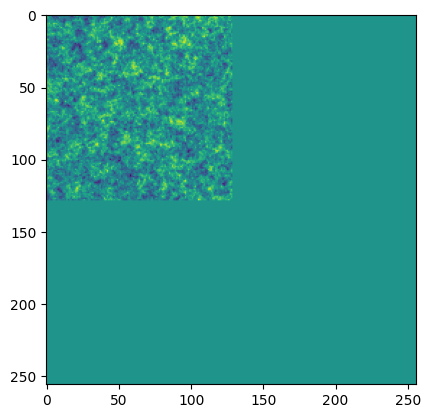

In [18]:
Pks = []
for ii in range(25):
    k_out, Pk_out = compute_sim(ii)
    Pks.append(Pk_out)

## NB: we have removed the mean of the box in the above!

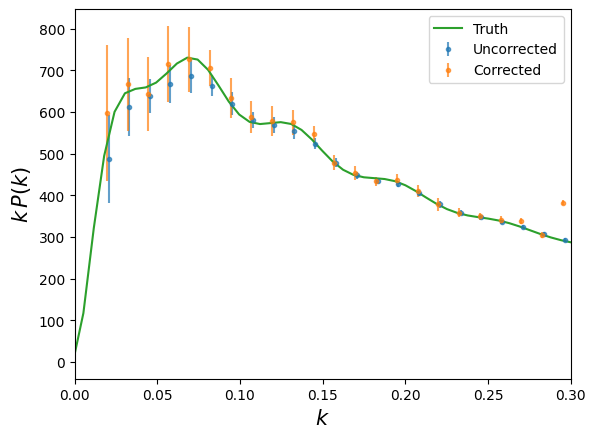

In [21]:
plt.errorbar(k_out+1e-3,k_out*np.mean(Pks,axis=0)/np.mean(filt**2),yerr=k_out*np.std(Pks,axis=0)/np.mean(filt**2),
             ls='',marker='.',alpha=0.7,label='Uncorrected')
f = (k_out>=0.00)
inv_mat = np.linalg.inv(Pk_mat[f][:,f]).T
PsC = [inv_mat@Pk[f] for Pk in Pks]
plt.errorbar(k_out[f],k_out[f]*np.mean(PsC,axis=0),yerr=k_out[f]*np.std(PsC,axis=0),label='Corrected',ls='',marker='.',
             alpha=0.7)
plt.plot(k_arr-1e-3,k_arr*pk_arr,label='Truth')
plt.xlim(0,0.3)
plt.legend()
plt.xlabel(r'$k$',fontsize=15);
plt.ylabel(r'$k\,P(k)$',fontsize=15);

In [32]:
def compute_reflect_sim(seed, plot=True, kmax=0.3):
    density_r = DFL.gaussian_field_3D(grid, k_arr.astype(float32), pk_arr.astype(float32), 1, seed,
                                  BoxSize, 1, False)

    # Cut most of this out
    density_cut = np.zeros_like(density_r)
    m = grid//2
    for i in range(2):
        for j in range(2):
            for k in range(2):
                ia = 1*(i==0)-1*(i==1)
                ja = 1*(j==0)-1*(j==1)
                ka = 1*(k==0)-1*(k==1)
                print(ia,ja,ka)
                density_cut[m*i:m*(i+1),m*j:m*(j+1),m*k:m*(k+1)] = density_r[:m:ia,:m:ja,:m:ka]
    
    if plot: plt.imshow(density_cut[:,:,:grid//2].mean(axis=2))
    return

    density_cut = density_r*filt
    density_cut -= np.mean(density_cut)
    if plot: plt.imshow(density_cut[:,:,:grid//2].mean(axis=2))
    
    # Compute power spectrum (dropping first mode [old fundamental])
    Pk = PKL.Pk(density_cut.astype('float32'), BoxSize, -1, 'None', threads, False)
    k_out = Pk.k3D[1:]
    Pk_out = Pk.Pk[1:,0]
    Nmodes = Pk.Nmodes3D[1:]
    
    # Rebin since fundamental has changed
    k_out =  (k_out[1::2]*Nmodes[1::2] +k_out[:-1:2] *Nmodes[:-1:2])/(Nmodes[1::2]+Nmodes[:-1:2])
    Pk_out = (Pk_out[1::2]*Nmodes[1::2]+Pk_out[:-1:2]*Nmodes[:-1:2])/(Nmodes[1::2]+Nmodes[:-1:2])
    
    return k_out[k_out<kmax], Pk_out[k_out<kmax]

In [33]:
compute_reflect_sim(42)

1 1 1
1 1 -1


ValueError: could not broadcast input array from shape (128,128,127) into shape (128,128,128)